In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import drpy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import shapely.geometry as sgeom
from matplotlib.gridspec import GridSpec
from datetime import datetime
from matplotlib.animation import ArtistAnimation
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)
import sys
sys.path.insert(1, '/home/alfonso/Documents/camp2ex_proj/src')
from utils import time_3d
plt.rcParams['animation.html'] = 'jshtml'
%matplotlib inline

In [2]:
ds_xr = xr.open_zarr('/media/alfonso/drive/Alfonso/camp2ex_proj/zarr/apr3.zarr')

In [3]:
ds_xr

<xarray.Dataset>
Dimensions:            (bin_size: 1, cross_track: 25, range: 456, time: 60275, vector: 3)
Coordinates:
    alt3d              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>
  * cross_track        (cross_track) int64 0 1 2 3 4 5 6 ... 19 20 21 22 23 24
    lat3d              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>
    lon3d              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>
  * time               (time) datetime64[ns] 2019-08-24T20:29:47.649800 ... 2...
Dimensions without coordinates: bin_size, range, vector
Data variables: (12/57)
    DR                 (bin_size) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Xat_km             (cross_track, time) float64 dask.array<chunksize=(25, 356), meta=np.ndarray>
    alt3D              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>
    alt_nav            (cross_track, time) float64 dask.array<chunksize=(25, 356), meta=np.ndarray>
    altsurf14          (cross_track, time) float64 dask.array<chunksize=(25, 356), meta=np.ndarray>
    altsurf35          (cross_track, time) float64 dask.array<chunksize=(25, 356), meta=np.ndarray>
    ...                 ...
    vel35SP            (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>
    vel95s             (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>
    zhh14              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>
    zhh14SP            (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>
    zhh35              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>
    zhh35SP            (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 89), meta=np.ndarray>

In [4]:
ds_xr.time

<xarray.DataArray 'time' (time: 60275)>
array(['2019-08-24T20:29:47.649800000', '2019-08-24T20:29:49.499800000',
       '2019-08-24T20:29:51.349800000', ..., '2019-10-05T00:52:44.299800000',
       '2019-10-05T00:52:46.149800000', '2019-10-05T00:52:47.999800000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-08-24T20:29:47.649800 ... 2019-10-05T...

In [5]:
ds_xr.time.min()

<xarray.DataArray 'time' ()>
array('2019-08-24T20:29:47.649800000', dtype='datetime64[ns]')

In [6]:
ds_xr.time.max()

<xarray.DataArray 'time' ()>
array('2019-10-05T00:52:47.999800000', dtype='datetime64[ns]')

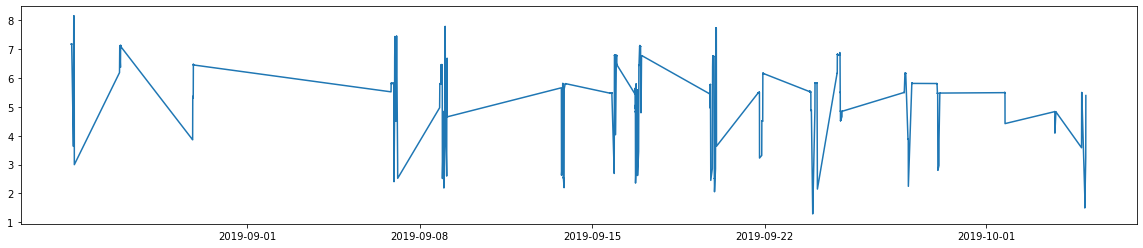

In [7]:
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(ds_xr.time, ds_xr.alt_nav[12, :] / 1000)

In [8]:
ds_aug = ds_xr.sel(time=('2019-08'))

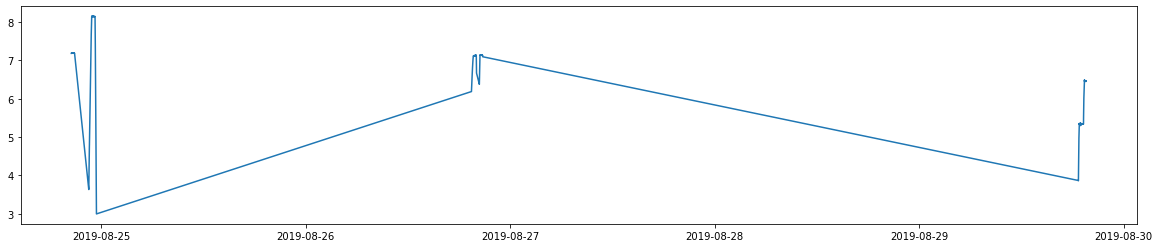

In [9]:
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(ds_aug.time, ds_aug.alt_nav[12, :] / 1000)

In [10]:
 _, index = np.unique(ds_xr['time'], return_index=True)
ds_nw = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())

In [11]:
ds_dates = ds_nw.sel(time=slice('2019-09-15 22:12', '2019-09-15 22:14'))

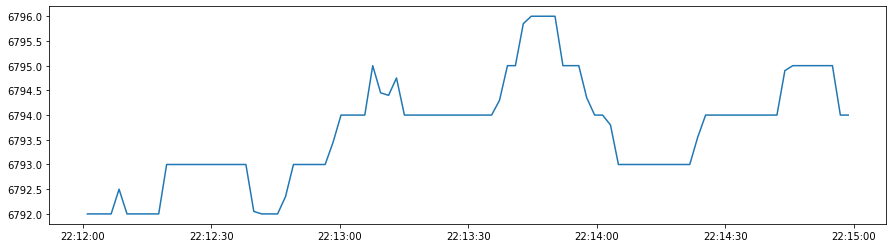

In [12]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(ds_dates.time, ds_dates.alt_nav[12, :])

execution time: 0:00:48.533225


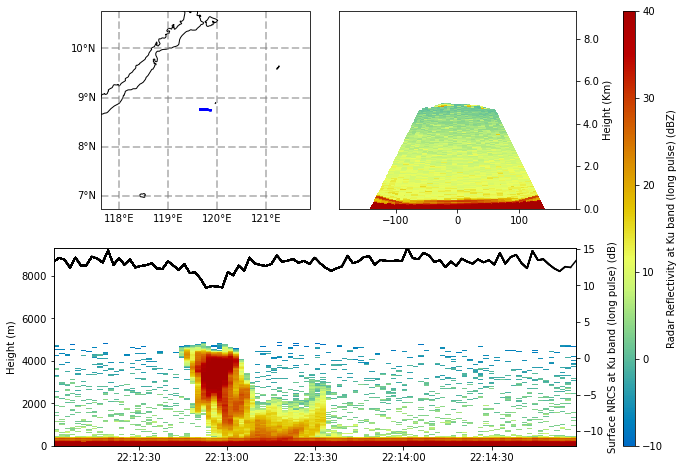

In [40]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[-1, :])
ax4 = ax3.twinx()

artist = []
now = datetime.now()
for _time in ds_dates.time:
    time = _time
    ax1.set_extent([ds_dates.lon.max() + 2, ds_dates.lon.min() - 2, 
                    ds_dates.lat.min() - 2, ds_dates.lat.max() + 2], 
                   crs=ccrs.Geodetic())
    if time == ds_dates.time.min():
        _lon = ds_dates.lon.sel(time=slice(ds_dates.time.min(), time))
        _lat = ds_dates.lat.sel(time=slice(ds_dates.time.min(), time))
    else:
        _lon = ds_dates.lon.sel(time=slice(ds_dates.time.min(), time)).values[12, :]
        _lat = ds_dates.lat.sel(time=slice(ds_dates.time.min(), time)).values[12, :]
        
    track = sgeom.LineString(zip(_lon, _lat))
    im1 = ax1.add_geometries([track], ccrs.PlateCarree(), facecolor='none', edgecolor='blue',
                       linewidth=2)

    x = ds_dates.range * np.sin(np.deg2rad(ds_dates.azimuth.sel(time=time)))
    y = ds_dates.alt3D.sel(time=time) * np.cos(np.deg2rad(ds_dates.azimuth.sel(time=time)))
    im2 = ax2.pcolormesh(x, y, ds_dates.zhh14.sel(time=time), 
                         cmap=drpy.graph.cmaps.HomeyerRainbow, vmin=-10, vmax=40)
    # ax2.invert_yaxis()  # for plane relative coordinates
    ax2.set_ylim(0, y.max())
    times_3d = time_3d(ds_dates.scantime.sel(time=slice(ds_dates.time.min(), time)), 
                       ds_dates.alt3D.shape[0])
    im3 = ax3.pcolormesh(times_3d[:, 12, :],
                       ds_dates.alt3D.sel(time=slice(ds_dates.time.min(), time))[:, 12, :],
                       ds_dates.zhh14.sel(time=slice(ds_dates.time.min(), time))[:, 12, :],
                       cmap=drpy.graph.cmaps.HomeyerRainbow, vmin=0, vmax=40)
    ax3.set_ylim(0, y.max())
    ax3.set_xlim(ds_dates.time.min(), ds_dates.time.max())
    im4, = ax4.plot(times_3d[0, 12, :], ds_dates.s0hh14.sel(time=slice(ds_dates.time.min(), time))[12], 'k')
    ax4.set_ylim(ds_dates.s0hh14.min(), ds_dates.s0hh14.max())
    artist.append([im1, im2, im3, im4])
    
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                   alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax1.coastlines()
labels = [i / 1000 for i in ax2.get_yticks()]
ax2.set_yticklabels(labels)
ax2.set_ylabel('Height (Km)')
ax2.yaxis.set_label_position("right")

ax2.yaxis.tick_right()

cbar2 = plt.colorbar(im2, ax=[ax2, ax3], orientation='vertical', aspect=35,  pad=0.07)
cbar2.set_label(f'{ds_dates.zhh14.notes} ({ds_dates.zhh14.units})')
ax3.set_ylabel('Height (m)')
ax4.set_ylabel(f'{ds_dates.s0hh14.notes} ({ds_dates.s0hh14.units})')
end = datetime.now()
print(f'execution time: {(end - now)}')

In [41]:
anim = ArtistAnimation(fig, artist, interval=100, blit=True)
anim